Importing the libraries needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

Loading in the data, and printing the first values

In [2]:
events = pd.read_csv('/Users/nickking/PycharmProjects/Pyhcarm/xG mess/events.csv')
info = pd.read_csv('/Users/nickking/PycharmProjects/Pyhcarm/xG mess/ginf.csv')

Checking the columns of our datasets to validate model

In [3]:
events.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
      dtype='object')

In [4]:
info.columns

Index(['id_odsp', 'link_odsp', 'adv_stats', 'date', 'league', 'season',
       'country', 'ht', 'at', 'fthg', 'ftag', 'odd_h', 'odd_d', 'odd_a',
       'odd_over', 'odd_under', 'odd_bts', 'odd_bts_n'],
      dtype='object')

Merging the dataset on id, to obtain information all in one dataframe

In [5]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
events.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break',
       'country', 'date'],
      dtype='object')

Creating the data for our pie chart

In [6]:
shotspie = events.groupby('shot_outcome').size().rename_axis('shot_outcome')
outcome_labels = {
    1.0:'On Target',
    2.0:'Off Target',
    3.0:'Blocked',
    4.0:'Hit The Bar'
}
shotspie.rename(index=outcome_labels, inplace=True)
shotspie.head()

shot_outcome
On Target      78014
Off Target     92827
Blocked        54082
Hit The Bar     3575
dtype: int64

Adding outcome labels so that the pie chart shows what actually happened rather than just 1,2,3,4

In [7]:
outcome_labels = {
    1.0: 'On Target',
    2.0: 'Off Target',
    3.0: 'Blocked',
    4.0: 'Hit The Bar',
    0.0: 'No Shot', 
}

events['shot_outcome_label'] = events['shot_outcome'].map(outcome_labels)

player_outcome_counts = events.groupby(['player', 'shot_outcome_label']).size().reset_index(name='count')

player_outcome_counts.head(20)



,player,shot_outcome_label,count
0,aaron,Blocked,12
1,aaron,Off Target,20
2,aaron,On Target,16
3,aaron cresswell,Blocked,15
4,aaron cresswell,Hit The Bar,2
5,aaron cresswell,Off Target,19
6,aaron cresswell,On Target,16
7,aaron hunt,Blocked,69
8,aaron hunt,Hit The Bar,4
9,aaron hunt,Off Target,64


Plotting it

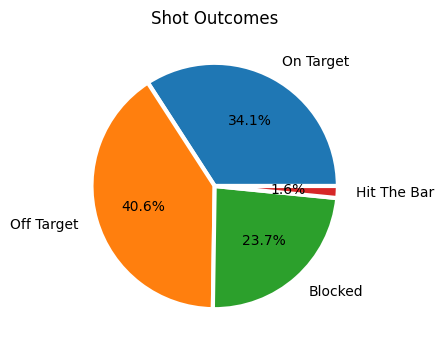

In [8]:
labels = shotspie.index
plt.figure(figsize=(5,4))
plt.pie(shotspie,
        labels=labels,
        autopct='%1.1f%%',
        labeldistance=1.15,
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title('Shot Outcomes')
plt.show()

Plotting a pie chart for individual players

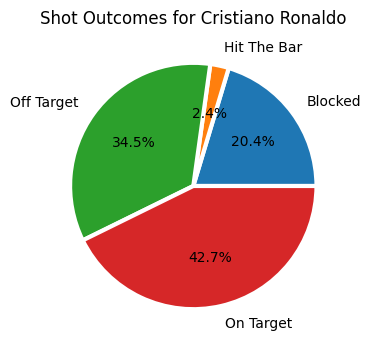

In [9]:
requested_player = 'cristiano ronaldo'

player_data = player_outcome_counts[player_outcome_counts['player'] == requested_player]

shotspie = player_data['count']
labels = player_data['shot_outcome_label']

plt.figure(figsize=(5,4))
plt.pie(shotspie,
        labels=labels,
        autopct='%1.1f%%',
        labeldistance=1.15,
        wedgeprops={'linewidth': 3, 'edgecolor': 'white'})
plt.title(f'Shot Outcomes for {requested_player.title()}')
plt.show()

Plotting a bar chart for the distribution of shots in total

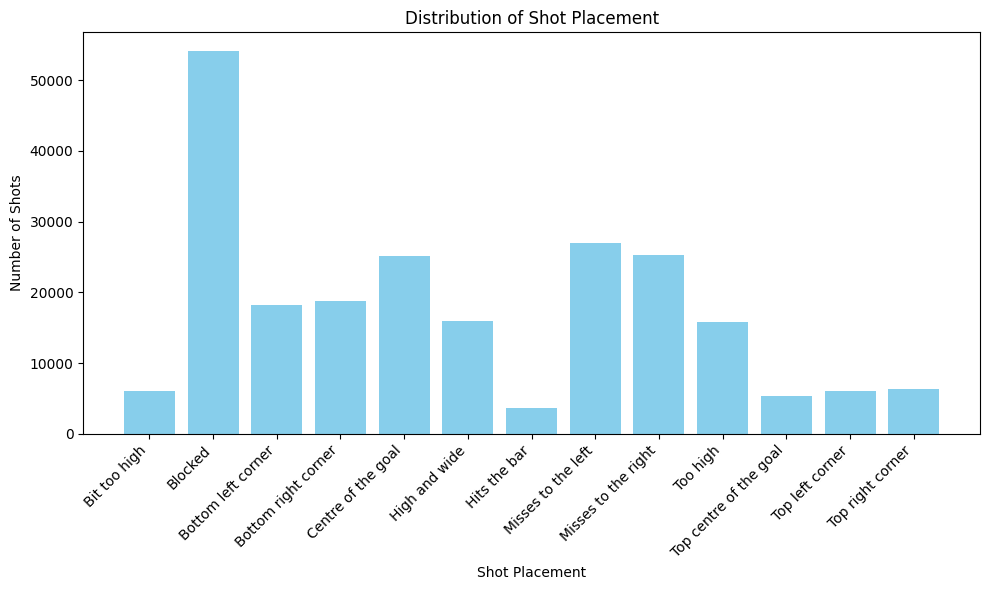

In [10]:
shotsbar = events[['shot_place', 'id_event']].groupby('shot_place').size().reset_index(name='count')
shotsbar.shot_place = shotsbar.shot_place.astype(int)
shotsbar.shot_place = shotsbar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})
plt.figure(figsize=(10, 6))
plt.bar(shotsbar['shot_place'], shotsbar['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Shot Placement')
plt.xlabel('Shot Placement')
plt.ylabel('Number of Shots')
plt.tight_layout()
plt.show()

New dataframe for goals per country

In [11]:
goals = events[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).size().reset_index(name='count')
goals.head(10)

,is_goal,country,count
0,0,england,115368
1,0,france,203247
2,0,germany,169952
3,0,italy,221636
4,0,spain,206360
5,1,england,3552
6,1,france,5199
7,1,germany,4621
8,1,italy,5491
9,1,spain,5583


Showing the conversion rate of shots among nations

In [12]:
shots = events[events['shot_outcome'].notna()]
goals = shots.groupby(['country', 'is_goal']).size().reset_index(name='count')
total_per_country = goals.groupby('country')['count'].transform('sum')
goals['percentage'] = (goals['count'] / total_per_country * 100).round(2)

goals[['country', 'is_goal', 'count', 'percentage']].head(10)

#shows that 10-11% of shots are goals


,country,is_goal,count,percentage
0,england,0,30360,89.79
1,england,1,3451,10.21
2,france,0,43792,89.66
3,france,1,5048,10.34
4,germany,0,36916,89.11
5,germany,1,4512,10.89
6,italy,0,49244,90.18
7,italy,1,5360,9.82
8,spain,0,44370,89.07
9,spain,1,5445,10.93


In [13]:
pivot = goals.pivot(index='country', columns='is_goal', values='percentage')
pivot.columns = ['Missed %', 'Scored %']
pivot = pivot[['Missed %', 'Scored %']]  

pivot.head()

,Missed %,Scored %
country,,
england,89.79,10.21
france,89.66,10.34
germany,89.11,10.89
italy,90.18,9.82
spain,89.07,10.93


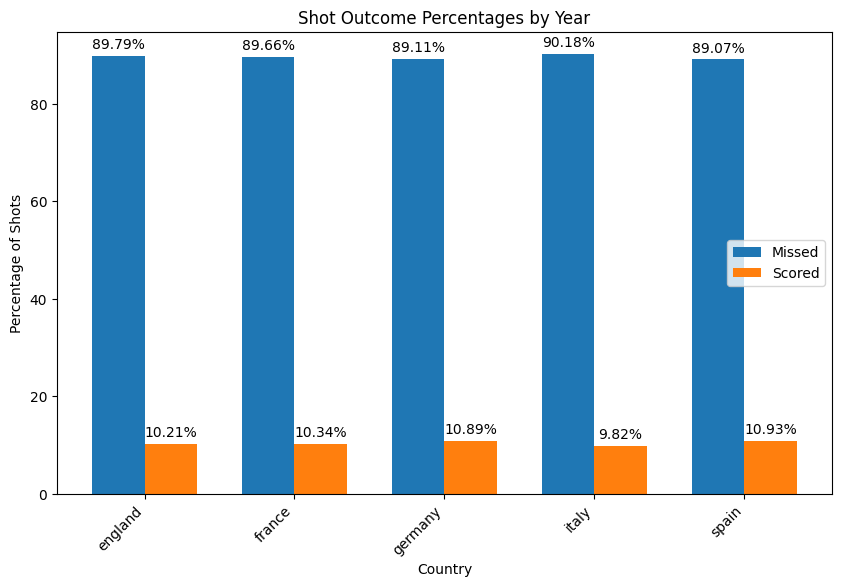

In [14]:
x = np.arange(len(pivot)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 6))
bars_missed = ax.bar(x - width/2, pivot['Missed %'], width, label='Missed')
bars_scored = ax.bar(x + width/2, pivot['Scored %'], width, label='Scored')
ax.set_ylabel('Percentage of Shots')
ax.set_xlabel('Country')
ax.set_title('Shot Outcome Percentages by Year')
ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45, ha='right')
ax.legend()
for bars in [bars_missed, bars_scored]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


Finding the percentage of shots scored by year, see if it remains consistent

In [15]:
#Extract the year from the date to group by year

events['date'] = pd.to_datetime(events['date'])
events['year'] = events['date'].dt.year

#Shot Percentage Scored By Year

shots = events[events['shot_outcome'].notna()]
goals = shots.groupby(['year', 'is_goal']).size().reset_index(name='count')
total_per_country = goals.groupby('year')['count'].transform('sum')
goals['percentage'] = (goals['count'] / total_per_country * 100).round(2)

goals[['year', 'is_goal', 'count', 'percentage']].head(10)

,year,is_goal,count,percentage
0,2011,0,14540,89.99
1,2011,1,1617,10.01
2,2012,0,32523,89.51
3,2012,1,3813,10.49
4,2013,0,35019,89.53
5,2013,1,4094,10.47
6,2014,0,39964,89.83
7,2014,1,4526,10.17
8,2015,0,41000,89.81
9,2015,1,4652,10.19


Just plotting the above

Next, want to plot the percentage of shots which resulted in a goal per player, essentially most prolific

In [20]:
#creating the percentage of shots which were a goal per player
shots = events[events['shot_outcome'].notna()]
goals = shots.groupby(['player', 'is_goal']).size().reset_index(name='count')
total_per_player = goals.groupby('player')['count'].transform('sum')
goals['percentage'] = (goals['count'] / total_per_player * 100).round(2)

#Making the ouput more readable
pivot = goals.pivot(index='player', columns='is_goal', values='percentage').fillna(0)
pivot.columns = ['Missed %', 'Scored %']  # assuming is_goal=0 is Missed, 1 is Scored
pivot = pivot.sort_values(by='Scored %', ascending=False)
pivot['total_shots'] = goals.groupby('player')['count'].sum()

#Filtering to stop people who only had one shot topping the chart
filtered = pivot[pivot['total_shots'] >= 50]
filtered = filtered.sort_values(by='Scored %', ascending=False)
filtered.head(10)


,Missed %,Scored %,total_shots
player,,,
paul verhaegh,69.23,30.77,52
jussie,69.81,30.19,53
gonzalo rodriguez,70.42,29.58,71
bas dost,73.72,26.28,137
dario cvitanich,74.14,25.86,116
lisandro,74.60,25.40,63
javier hernandez,75.00,25.00,112
mohammed abdellaoue,75.00,25.00,80
miroslav klose,75.12,24.88,205


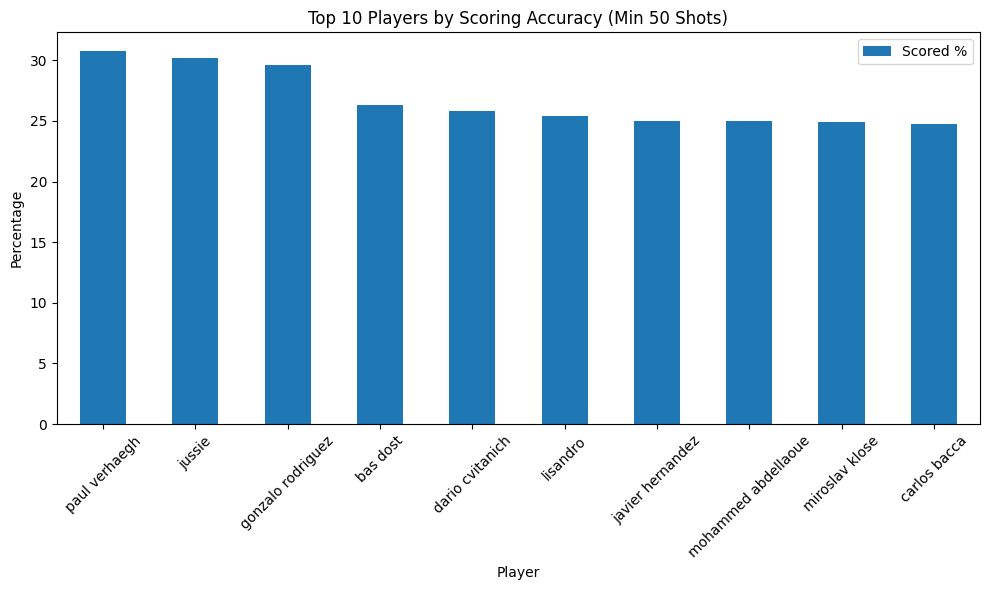

In [21]:
#Graphing the most prolific shooters
top = filtered.sort_values('Scored %', ascending=False).head(10)

top[['Scored %']].plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Top 10 Players by Scoring Accuracy (Min 50 Shots)')
plt.ylabel('Percentage')
plt.xlabel('Player')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


This is the most prolific scorers per year

In [22]:
#Most prolific scorers by year
shots = events[events['shot_outcome'].notna()]

shots_per_player_year = shots.groupby(['year', 'player']).size().reset_index(name='total_shots')
goals_per_player_year = shots[shots['is_goal'] == 1].groupby(['year', 'player']).size().reset_index(name='goals')

prolific = pd.merge(shots_per_player_year, goals_per_player_year, on=['year', 'player'], how='left')
prolific['goals'] = prolific['goals'].fillna(0)

prolific['goal_percentage'] = (prolific['goals'] / prolific['total_shots'] * 100).round(2)

prolific = prolific.sort_values(by=['year', 'total_shots'], ascending=[True, False])

top_prolific_each_year = prolific.groupby('year').head(5)

print(top_prolific_each_year)



       year               player  total_shots  goals  goal_percentage
294    2011    cristiano ronaldo           90   19.0            21.11
849    2011         lionel messi           77   17.0            22.08
1077   2011                 nene           77    8.0            10.39
1105   2011       olivier giroud           68   13.0            19.12
144    2011    antonio di natale           66    9.0            13.64
1861   2012    cristiano ronaldo          269   38.0            14.13
2614   2012         lionel messi          205   59.0            28.78
3463   2012   zlatan ibrahimovic          168   35.0            20.83
1656   2012    antonio di natale          148   22.0            14.86
2076   2012               falcao          138   32.0            23.19
3923   2013    cristiano ronaldo          233   38.0            16.31
5807   2013   zlatan ibrahimovic          163   27.0            16.56
4933   2013      mario balotelli          151   18.0            11.92
4077   2013       ed

/var/folders/1m/k225dj3x4yz7mpfywd8kznt80000gn/T/ipykernel_9232/4196793912.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_each_year = top_prolific_each_year.groupby('year').apply(lambda df: df.nlargest(5, 'goal_percentage')


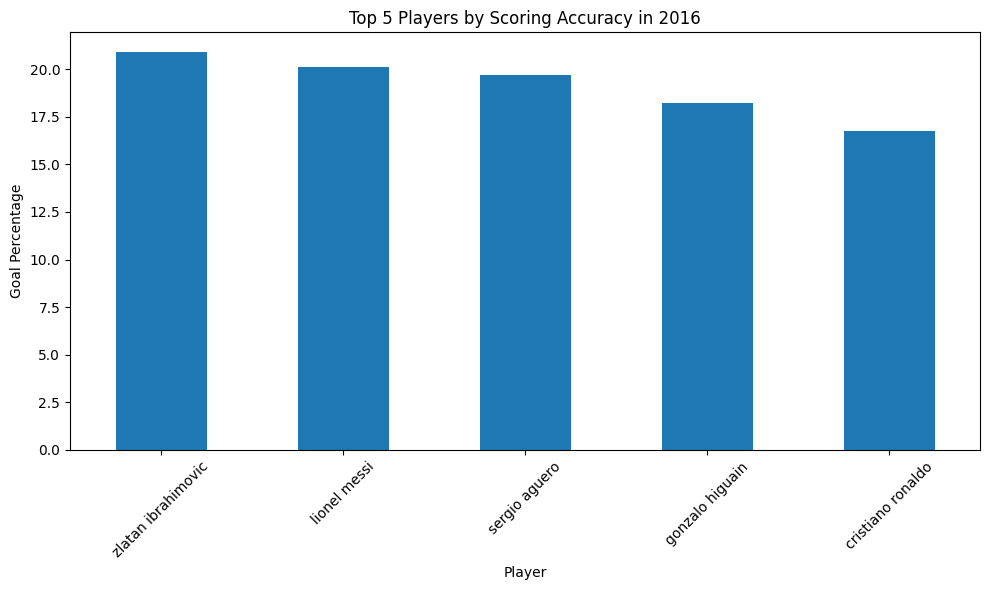

In [23]:
# For each year, get top 5 players by goal_percentage
top_each_year = top_prolific_each_year.groupby('year').apply(lambda df: df.nlargest(5, 'goal_percentage')
).reset_index(drop=True)

top_2016 = top_each_year[top_each_year['year'] == 2016]
top_2016.set_index('player')['goal_percentage'].plot(kind='bar', figsize=(10,6))
plt.title('Top 5 Players by Scoring Accuracy in 2016')
plt.ylabel('Goal Percentage')
plt.xlabel('Player')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Starting the Machine Learning process

In [24]:
#Starting the xG model
data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
data['is_goal'] = shots['is_goal']

print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)
#shows how many shots and how many goals. For each shot, there are 28 charateristics to describe it

KeyError: "['location'] not in index"

In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

Gradient Boosting Classifier

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model(params): 
    model = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    model.fit(X_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test)),
        'train_accuracy': model.score(X_train, y_train),
        'test_accuracy': model.score(X_test, y_test),
    }

def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['test_ROCAUC']
    res['status'] = STATUS_OK
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
);

pd.DataFrame(trials.results).sort_values(by='f1_score', ascending=False).head(5)

Running the model on our most effective hyperparameters

In [ ]:
model = GradientBoostingClassifier(
                        learning_rate=0.083848,
                        min_samples_leaf=26,
                        max_depth = 6,
                        max_features = 17
                        )
model.fit(X_train, y_train)
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

In [ ]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

Above is measuring our most effective hyperparamaters performance and below is a confusion matrix

In [ ]:
class color:
    BOLD = '\033[1m'
    YELLOW = '\033[93m'
    END = '\033[0m'
print(color.BOLD + color.YELLOW + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Logistic Regression Model

In [ ]:
model = LogisticRegression(max_iter=400)
model.fit(X_train, y_train)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=400, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Performance statistics

In [ ]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

In [ ]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

In [ ]:
print(color.BOLD + color.YELLOW + color.BOLD + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + color.BOLD + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Hyperparamaters

In [ ]:
model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
model.fit(X_train, y_train)

Evaluating the model's performance

In [ ]:
shots['prediction'] = model.predict_proba(X)[:, 1]
shots['difference'] = shots['prediction'] - shots['is_goal']